# Appendix - Code for converting the Caffe model to Tensorflow
Model from Fully Convolutional Networks(FCN) for Semantic Segmentation by Jonathan Long*, Evan Shelhamer*, and Trevor Darrell. CVPR 2015 and PAMI 2016 
https://github.com/shelhamer/fcn.berkeleyvision.org/tree/master/voc-fcn32s   

This notebook is for converting the pre-trained FCN semantic segmentation model from Caffe to Tensorflow. We only convert the encoding part (toward "fc7" named in the paper), because we want to extract feature from that layer, which is 7x7x4096.

In [1]:
import os
import h5py

import matplotlib.pyplot as plt
import time, pickle, pandas

import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, Deconvolution2D, Cropping2D, UpSampling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Reshape
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras import backend
from keras import optimizers

%matplotlib inline

Using TensorFlow backend.


In [3]:
# dimensions of our images.
img_width, img_height = 224, 224

# train_data_dir = './data/train'
validation_data_dir = './fcn.berkeleyvision.org/data/pascal/VOC2011/JPEGImages'
nb_train_samples = 20000
nb_validation_samples = 2000

In [4]:
def build_fcn32(framework='tf'):

    if framework == 'th':
        # build the VGG16 network in Theano weight ordering mode
        backend.set_image_dim_ordering('th')
    else:
        # build the VGG16 network in Tensorflow weight ordering mode
        backend.set_image_dim_ordering('tf')
        
    model = Sequential()
    if framework == 'th':
        model.add(ZeroPadding2D((100, 100), input_shape=(3, img_height, img_width)))
    else:
        model.add(ZeroPadding2D((100, 100), input_shape=(img_height, img_width, 3)))
        
    model.add(Conv2D(64, (3, 3), activation='relu', name='conv1_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(64, (3, 3), activation='relu', name='conv1_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='pool1'))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(128, (3, 3), activation='relu', name='conv2_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(128, (3, 3), activation='relu', name='conv2_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='pool2'))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu', name='conv3_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu', name='conv3_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu', name='conv3_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='pool3'))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu', name='conv4_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu', name='conv4_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu', name='conv4_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='pool4'))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu', name='conv5_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu', name='conv5_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu', name='conv5_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='pool5'))
    
    # build a convolutional layer to put on top of the convolutional model, to create an FCN
    model.add(Conv2D(4096, (7, 7), activation='relu', name='fc6'))
    model.add(Dropout(0.5, name='drop6'))
    model.add(Conv2D(4096, (1, 1), activation='relu', name='fc7'))
    model.add(Dropout(0.5, name='drop7'))

    # Final segmentation layer
    model.add(Conv2D(21, (1, 1), name='score_fr'))

### We dont need the deconvolution part from FCN ###
#     model.add(Deconvolution2D(21, 64, 64, subsample=(32, 32), bias=False, output_shape=(None, 384, 512, 21), name='upscore'))
#     model.add(UpSampling2D(size=(32, 32), name='upsample'))
#     model.add(ZeroPadding2D((32, 32)))
#     model.add(Convolution2D(21, 64, 64, bias=False, name='upscore'))
    
    # Find the shape of the output from the previous layer
#     output_shape = model.layers[-1].output_shape[1]
#     crop_size = (int((output_shape - img_width)/2), int((output_shape - img_height)/2))
#     model.add(Cropping2D((crop_size, crop_size), name='score'))
    
#     # Reshape to apply pixel-wise softmax
#     _, curr_width, curr_height, curr_filters = model.layers[-1].output_shape
#     model.add(Reshape((curr_width * curr_height, curr_filters)))
#     model.add(Activation('softmax'))
#     model.add(Reshape((curr_width, curr_height, curr_filters)))
    
    return model

Build a Tensorflow style model and load the weights from the Caffe model file

In [5]:
# path to the model weights file - gotten by converting from Caffe
weights_path = 'seg_model_init_weights.h5'
tf_model = build_fcn32('tf')

In [6]:
print('Keras:')
for layer in tf_model.layers:
    print(layer.name)
    if len(layer.get_weights()) > 0:
        w = layer.get_weights()[0]
        print(w.shape)

Keras:
zero_padding2d_1
conv1_1
(3, 3, 3, 64)
zero_padding2d_2
conv1_2
(3, 3, 64, 64)
pool1
zero_padding2d_3
conv2_1
(3, 3, 64, 128)
zero_padding2d_4
conv2_2
(3, 3, 128, 128)
pool2
zero_padding2d_5
conv3_1
(3, 3, 128, 256)
zero_padding2d_6
conv3_2
(3, 3, 256, 256)
zero_padding2d_7
conv3_3
(3, 3, 256, 256)
pool3
zero_padding2d_8
conv4_1
(3, 3, 256, 512)
zero_padding2d_9
conv4_2
(3, 3, 512, 512)
zero_padding2d_10
conv4_3
(3, 3, 512, 512)
pool4
zero_padding2d_11
conv5_1
(3, 3, 512, 512)
zero_padding2d_12
conv5_2
(3, 3, 512, 512)
zero_padding2d_13
conv5_3
(3, 3, 512, 512)
pool5
fc6
(7, 7, 512, 4096)
drop6
fc7
(1, 1, 4096, 4096)
drop7
score_fr
(1, 1, 4096, 21)


In [7]:
import caffe
from PIL import Image

In [8]:
%cd fcn.berkeleyvision.org/

C:\Users\Aditya\Documents\Columbia Courses\Spring 2017\COMS W4995_Deep_Learning_for_CV\Project\fcn.berkeleyvision.org


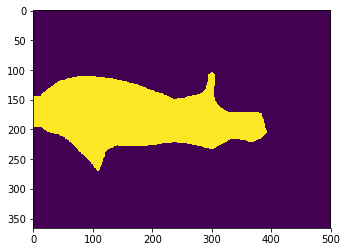

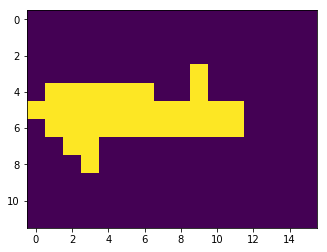

In [9]:
net = caffe.Net('voc-fcn32s/val.prototxt', 'voc-fcn32s/fcn32s-heavy-pascal.caffemodel', caffe.TEST)
# run net and take argmax for prediction
net.forward()

# Check shapes at output
out = net.blobs['score'].data[0].argmax(axis=0)
plt.imshow(out)
plt.show()

# Show output from the score_fr layer
inter = net.blobs['score_fr'].data[0].argmax(axis=0)
plt.imshow(inter)
plt.show()

In [10]:
for layer_name in net.params.keys():
    print(layer_name)
    print(net.params[layer_name][0].data.shape)

conv1_1
(64, 3, 3, 3)
conv1_2
(64, 64, 3, 3)
conv2_1
(128, 64, 3, 3)
conv2_2
(128, 128, 3, 3)
conv3_1
(256, 128, 3, 3)
conv3_2
(256, 256, 3, 3)
conv3_3
(256, 256, 3, 3)
conv4_1
(512, 256, 3, 3)
conv4_2
(512, 512, 3, 3)
conv4_3
(512, 512, 3, 3)
conv5_1
(512, 512, 3, 3)
conv5_2
(512, 512, 3, 3)
conv5_3
(512, 512, 3, 3)
fc6
(4096, 512, 7, 7)
fc7
(4096, 4096, 1, 1)
score_fr
(21, 4096, 1, 1)
upscore
(21, 21, 64, 64)


In [11]:
# Create another net to take only the necessary layers
pruned_net = caffe.Net('voc-fcn32s/pruned_model.prototxt', caffe.TEST)
# Load in weights for the layers
for layer_name in pruned_net.params.keys():
    # Find corresponding weights in the original network
    if layer_name in net.params.keys():
        # Transfer weights
        pruned_net.params[layer_name][0].data.flat = net.params[layer_name][0].data.flat
        pruned_net.params[layer_name][1].data[...] = net.params[layer_name][1].data

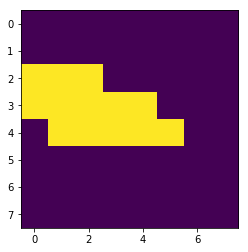

In [12]:
# Check output from the network
# load image, switch to BGR, subtract mean, and make dims C x H x W for Caffe
pruned_net = caffe.Net('voc-fcn32s/pruned_model.prototxt', 'voc-fcn32s/fcn32s-pruned.caffemodel', caffe.TEST)
im = Image.open('data/pascal/VOC2011/JPEGImages/2007_000033.jpg')
im = im.resize((img_width, img_height), Image.ANTIALIAS)
in_ = np.array(im, dtype=np.float32)
in_ = in_[:,:,::-1]
in_ -= np.array((104.00698793,116.66876762,122.67891434))
in_ = in_.transpose((2,0,1))

# shape for input (data blob is N x C x H x W), set data
pruned_net.blobs['data'].reshape(1, *in_.shape)
pruned_net.blobs['data'].data[...] = in_

pruned_net.forward()
# Show output from the score_fr layer
inter = pruned_net.blobs['score_fr'].data[0].argmax(axis=0)
plt.imshow(inter)
plt.show()

In [13]:
# Save new net weights
pruned_net.save('voc-fcn32s/fcn32s-pruned.caffemodel')

At this point, externally call the conversion code to give the Keras weights in the filename defined earlier

In [14]:
%cd ../

C:\Users\Aditya\Documents\Columbia Courses\Spring 2017\COMS W4995_Deep_Learning_for_CV\Project


In [15]:
# Load weights
f = h5py.File(weights_path)

In [16]:
### This is to be run for loading Keras HDF5 weights after conversion

# Find order using the .json file
import json

model_file = None
with open('seg_model_init_structure.json') as m:
    model_file = json.load(m)

for i, layer in enumerate(model_file['layers']):
    layer_name = layer['custom_name']
    weight_name = 'layer_{}'.format(i)
    # Find weights in the weights file
    weights = f[weight_name]
    if len(weights.keys()) > 0:
        w = np.transpose(weights['param_0'], (3, 2, 1, 0))
        new_weights = [w]
        if 'param_1' in weights:
            b = weights['param_1']
            new_weights.append(b)
        # Find the corresponding layer in the Keras model, copy the weights
        model_layer = tf_model.get_layer(layer_name)
        model_layer.set_weights(new_weights)

In [17]:
print (tf_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 424, 424, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 422, 422, 64)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 424, 424, 64)      0         
_________________________________________________________________
conv1_2 (Conv2D)             (None, 422, 422, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 211, 211, 64)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 213, 213, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 211, 211, 128)     73856     
__________

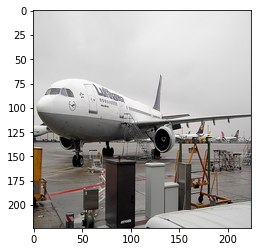

In [18]:
# Test out an image on the loaded network
from scipy import misc
image = Image.open('fcn.berkeleyvision.org/data/pascal/VOC2011/JPEGImages/2007_000033.jpg')
image = image.resize((img_width, img_height), Image.ANTIALIAS)
plt.imshow(image)
plt.show()
image = np.array(image, dtype=np.float32)
# Preprocess
# Switch to BGR
image = image[::-1]
# Subtract mean
image -= np.array((104.00698793,116.66876762,122.67891434))

In [19]:
# Predict segmentation output
x = tf_model.predict(np.array([image]), batch_size=1)

(7, 7)


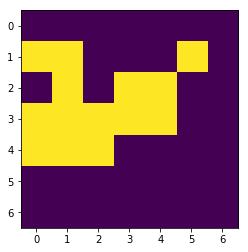

In [20]:
x_image = np.argmax(x[0], axis=2)
print(x_image.shape)
plt.imshow(x_image)

(Some differences to be expected from the original model, due to rounding errors, and also mismatches in the conversion of layers like Pooling between Caffe and Keras)

In [21]:
# Save final model along with weights to disk
tf_model.save('seg_model.h5')